In [2]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.MalonaldehydeAngles import MalonaldehydeAngles
from codes.otherfunctions.multirun import get_coeffs_reps
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell


from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M, dg_M, dg_w, dg_w_pca, dgw_norm)


#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0, 0, 0, 1, 1, 1, 2, 2])
jj = np.asarray([4, 5, 1, 6, 7, 2, 3, 8])
#run experiment
#these are just for loading... probably not necessary
atoms4 = np.asarray([[4,0,1,2],[0,1,2,3],[3,2,1,8],[4,0,1,5]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'


folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)


new_MN = True
new_grad = True
savename = 'malonaldehyde_010521_p12rep5n500_oldnorm'
savefolder = 'malonaldehyde'
loadfolder = 'malonaldehyde'
loadname = 'malonaldehyde_010521_p12rep5n500_oldnorm'

experiment = MalonaldehydeAngles(dim, ii, jj,cores,atoms4)
projector  = np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50_components.npy')
experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50.npy'), dim)
projector  = np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50_components.npy')
#experiment.M = experiment.load_data()  # if noise == False then noise parameters are overriden
#experiment.Mpca = RiemannianManifold(np.load(workingdirectory + '/untracked_data/chemistry_data/malonaldehydeangles022119_pca50.npy'), dim)
#     with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
#              'wb') as output:
#          pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)

In [3]:
experiment.q = m
experiment.m = m
experiment.dimnoise = dimnoise
experiment.projector = projector
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [4]:
selected_points = np.asarray([25019, 41544,  6706, 27564, 26068, 13504, 36105, 27942, 11049,
       23717,  2292, 47873, 20138, 42278, 46154, 12297, 48287, 45166,
       40886, 17256, 25582, 28876, 41968,  1578,  8242, 28597,  2232,
       18238,  8823, 10766, 31293, 46858,  7988, 16539, 13557,  3979,
       47118, 44390, 26033,  4447, 23260,  3573, 30099, 21740,  7717,
       37319, 28075, 22725,  1187, 34619,  8676, 12839,  6779, 27603,
       31362, 32106, 20716, 48386, 22942, 32936, 12642,  5820, 25561,
       31936, 28991, 22617, 11182, 31271,  6114,    49, 28499, 15575,
       39088, 17703, 35808, 42126, 24343,  2665,  7704,  9760,  7860,
       43634, 39084, 19025, 45113, 43693, 25208,  8890, 47184, 12130,
       19773, 25578, 30502, 31603, 45642,  7807, 13612, 10259, 21745,
       37625])

In [6]:
nreps = 1
atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))

print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    #selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate(nsel = 100, selected_points = selected_points)
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)


pre-gradient acquisition
2021-02-19 13:43:06.746358


In [8]:
replicates[0].df_M.shape

(100, 2, 3)

In [11]:
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel


In [12]:

gl_itermax = 500
r = 0 
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
results= {}
for r in range(nreps):
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    #to fix...
    #replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)
    #replicates[r].df_M = np.swapaxes(replicates[r].df_M,1,2)
    replicates[r].results = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)
    

initializing lambda search
converged 1.7239482028693363
0 0.8619741014346681 probe
1 1.2929611521520021 probe
converged 1.2929611521520021
we did it [ 3 10]


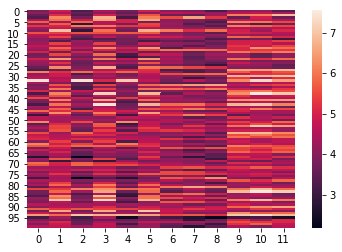

In [17]:
%matplotlib inline
sns.heatmap(np.linalg.norm(replicates[0].dg_M, axis = 1))

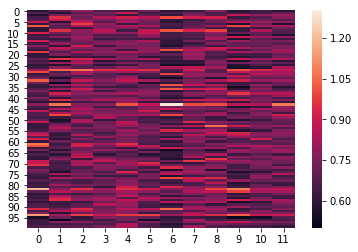

In [18]:
%matplotlib inline
sns.heatmap(np.linalg.norm(replicates[0].dg_w, axis = 2))

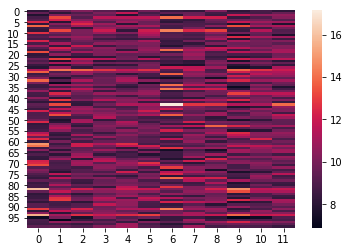

In [20]:
%matplotlib inline
sns.heatmap(np.linalg.norm(replicates[0].dgw_norm, axis = 2))

In [19]:
replicates[0].selected_points

array([25019, 41544,  6706, 27564, 26068, 13504, 36105, 27942, 11049,
       23717,  2292, 47873, 20138, 42278, 46154, 12297, 48287, 45166,
       40886, 17256, 25582, 28876, 41968,  1578,  8242, 28597,  2232,
       18238,  8823, 10766, 31293, 46858,  7988, 16539, 13557,  3979,
       47118, 44390, 26033,  4447, 23260,  3573, 30099, 21740,  7717,
       37319, 28075, 22725,  1187, 34619,  8676, 12839,  6779, 27603,
       31362, 32106, 20716, 48386, 22942, 32936, 12642,  5820, 25561,
       31936, 28991, 22617, 11182, 31271,  6114,    49, 28499, 15575,
       39088, 17703, 35808, 42126, 24343,  2665,  7704,  9760,  7860,
       43634, 39084, 19025, 45113, 43693, 25208,  8890, 47184, 12130,
       19773, 25578, 30502, 31603, 45642,  7807, 13612, 10259, 21745,
       37625])

In [ ]:
#get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)

In [23]:
#get_grads(experiment, Mpca, Mangles, N, selected_points):
Mpca = experiment.Mpca
Mangles = experiment.M
N = experiment.N

In [24]:
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)


In [26]:
tangent_bases[0]

array([[-4.02821519e-02,  4.13895916e-02],
       [ 3.78548574e-01,  8.82886425e-01],
       [-7.75829676e-01,  3.90819776e-01],
       [-4.14589450e-01,  1.04732906e-01],
       [-1.46887045e-01, -1.71973659e-01],
       [-2.03626983e-01,  5.92881855e-02],
       [ 2.52654714e-02, -9.32563684e-02],
       [-1.72866556e-02, -9.52241039e-03],
       [ 1.32242049e-02, -2.64328795e-03],
       [ 7.25185956e-02,  3.24960436e-02],
       [-3.89139709e-02,  8.93156025e-03],
       [-2.39469535e-02,  5.01895884e-02],
       [-4.01725706e-02,  1.09441471e-02],
       [-3.13460180e-02,  5.54509290e-04],
       [ 9.72200868e-03, -1.41905207e-02],
       [-2.45247319e-03,  4.59303035e-03],
       [ 2.06620900e-02,  4.06700031e-03],
       [-1.52192117e-02, -6.49234335e-02],
       [-2.28018190e-02, -3.32895039e-02],
       [ 5.01300620e-03,  1.03652235e-03],
       [-2.14859217e-02, -1.56394212e-02],
       [-1.84794136e-02,  3.70745583e-04],
       [-4.08529250e-02, -4.75194363e-02],
       [ 3.

In [28]:
experiment.Mpca.data[0]

array([ 1.01046914e+01,  3.02064716e-01,  2.80805587e+00, -3.69127599e-01,
       -1.56339331e+00,  8.41758988e-01, -2.01962385e-02,  7.71692324e-01,
        1.31027834e-01, -1.52598040e-01, -2.93409434e-02, -3.12598477e-01,
        2.20568108e-01,  4.49880878e-02,  1.94513625e-01,  1.06278199e-01,
        9.28505027e-02, -7.48483432e-02, -4.29369295e-02, -1.34334162e-01,
        1.49498739e-01, -1.23009305e-01, -2.94397869e-02, -3.41906721e-02,
       -1.56521599e-01, -9.60181908e-02, -1.17618943e-02, -5.91347360e-02,
        6.54311027e-04,  5.98091711e-02,  5.05899151e-02,  1.50857250e-03,
       -8.82445299e-03,  1.34068199e-01,  2.16350463e-02,  2.12072182e-02,
        4.19965799e-02, -1.98914721e-02,  4.49605551e-02,  4.50938268e-02,
       -1.22192435e-02,  3.58518559e-02, -5.84932614e-02, -4.43600897e-02,
        2.25832529e-02,  1.79891611e-02,  7.98400946e-02, -6.16305416e-03,
        9.59607628e-03, -8.05388087e-03])

In [29]:
experiment.M.data[0]

array([0.56882053, 1.97595479, 0.59681733, 0.42973475, 2.42858969,
       0.28326821, 2.12672185, 0.42586717, 0.58900363, 1.97069056,
       0.47832097, 0.69258113, 0.45859683, 2.01154886, 0.67144696,
       0.56582416, 1.67111444, 0.90465405, 1.00483599, 1.51930324,
       0.61745342, 0.17804923, 2.58627435, 0.37726907, 2.54558706,
       0.1833845 , 0.41262109, 1.52405291, 0.42252328, 1.19501647,
       0.98033163, 0.97097517, 1.19028585, 0.92441064, 0.8581203 ,
       1.35906172, 0.45809224, 1.45572906, 1.22777135, 2.37864719,
       0.17670601, 0.58623945, 1.701664  , 0.28556046, 1.15436819,
       0.810215  , 0.66678383, 1.66459383, 0.87974063, 0.56634343,
       1.6955086 , 0.63402614, 0.82149124, 1.68607528, 2.17699995,
       0.47415763, 0.49043508, 1.66813297, 1.02189897, 0.45156071,
       2.13233662, 0.64712787, 0.36212816, 2.82548992, 0.22132425,
       0.09477848, 2.42410537, 0.48445381, 0.23303347, 1.74122655,
       0.92723902, 0.47312709, 1.08150238, 1.62975131, 0.43033